In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import os
from PIL import Image

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
import time

/tmp/ipykernel_28474/2276582301.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
data_dir = 'data/water_normal'
transform = transforms.ToTensor()
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [14]:
import random

test_percentage = 0.3
all_numbers = list(range(len(dataset)))
random_numbers = random.sample(range(len(dataset)), int(len(dataset) * test_percentage))
remaining_numbers = list(set(all_numbers) - set(random_numbers))

test_set = torch.utils.data.Subset(dataset, random_numbers)  
train_set = torch.utils.data.Subset(dataset, remaining_numbers)

In [24]:
sample_transforms = {
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Rotation" : transforms.RandomAffine(degrees=60),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
#     "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),
}

transf_datasets = []
for _, t in sample_transforms.items():
    new_dataset = torch.utils.data.Dataset()
    for item in train_set:
        new_dataset.append(t(item))
    transf_datasets.append(new_dataset)
for new_dataset in transf_datasets:
    train_set.append(new_dataset)

def print_aug_img(img):
    pil_img = transforms.ToPILImage()(img)
    print(pil_img)
    rows = 2
    cols = 3
    f, axarr = plt.subplots(rows, cols)
    for count, (name, t) in enumerate(sample_transforms.items()):
        row = count % cols
        col = count // cols
        print(name, t(pil_img))
        axarr[col,row].imshow(t(pil_img), cmap='gray')
        axarr[col,row].set_title(name)
    plt.show()

AttributeError: 'Dataset' object has no attribute 'append'

In [15]:
print(len(test_set))
print(len(train_set))

75
176


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [17]:
def get_max_ind(list):
    max = float('-inf')
    max_ind = -1
    for i in range(len(list)):
        if (list[i] > max):
            max = list[i]
            max_ind = i
    return max_ind

In [18]:
def moveTo(obj, device):
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None, print_results=False):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        print_aug_img(inputs[0])

        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
            if (print_results):
                for ind in range(len(y_true)):
                    print("Expected: ", dataset.classes[y_true[ind]], " | Pred: ", dataset.classes[get_max_ind(y_pred[ind])])
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing", print_results=True)
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


In [19]:
D = 96*96
C = 3
classes = 18
filters = 16
K = 3

model_linear = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, 256),
    nn.Tanh(),
    nn.Linear(256, classes)
)

model_cnn_pool = nn.Sequential(
    nn.Conv2d(C, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(filters, filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2*filters*D//(4**2), classes),
)

model_cnn = nn.Sequential(
    nn.Conv2d(C, filters, K, padding=K//2),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(filters*D, classes)
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78138970>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78177790>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807E2740>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78080700>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7813A5F0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F8061F1AF50>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7869E0E0>


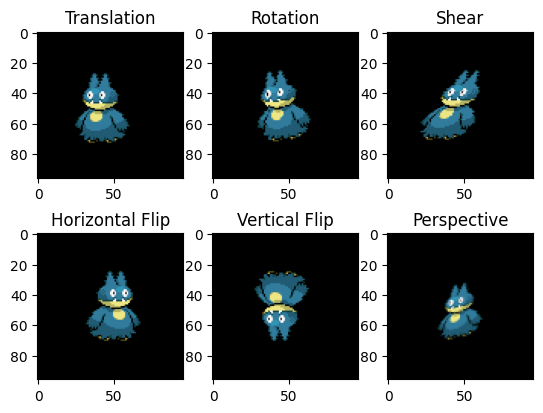

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78138970>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785E0940>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7859B2B0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803AF250>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784AB940>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7864C130>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80112590>


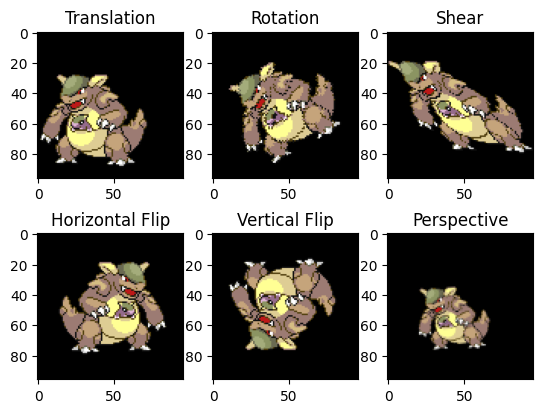

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784A8910>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7840C970>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786BB640>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7821E9E0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80382620>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786E8580>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809237C0>


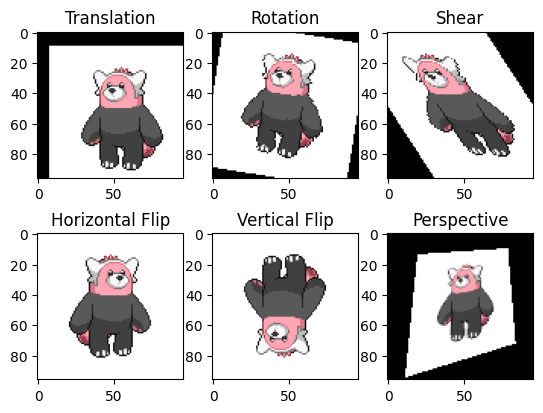

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7840CAC0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787F85E0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F805AF820>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A1F00>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8049C370>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780E4FA0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787FA020>


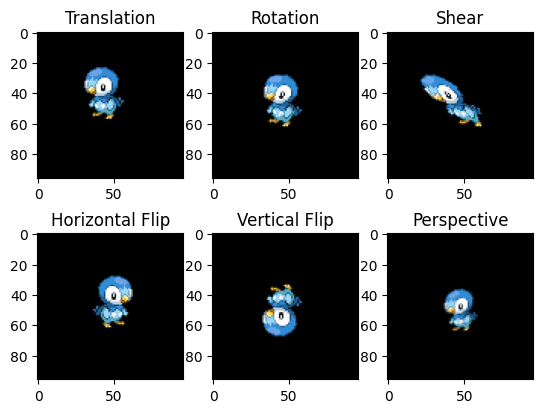

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7838BEE0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78164B50>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8016EBC0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083FA60>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78728CA0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7859DC90>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78166D70>


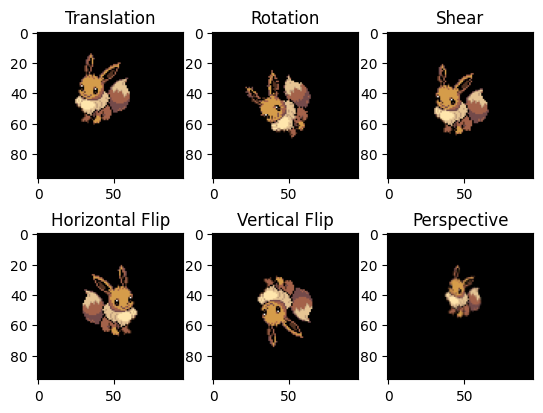

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784779A0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8015C100>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808CAA70>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7822E590>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78106830>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7822F5E0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8015ED10>


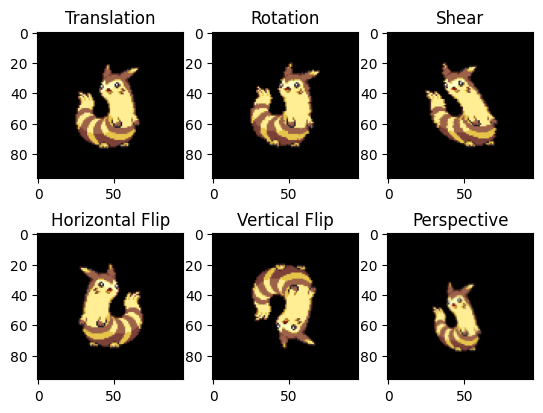

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82433B80>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783B9F90>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82478C10>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8249D7B0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803EBE50>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824D65C0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803EA830>


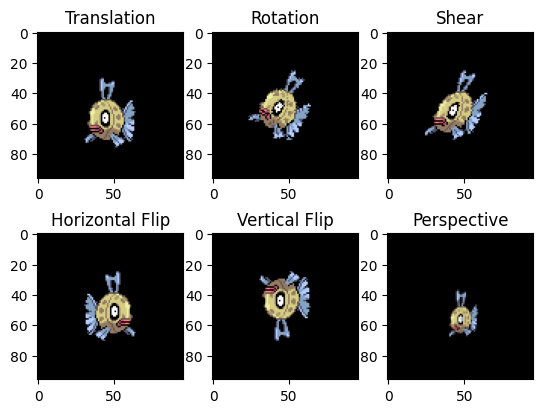

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


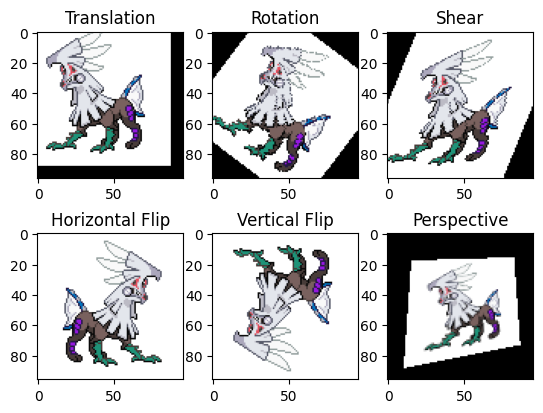

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred

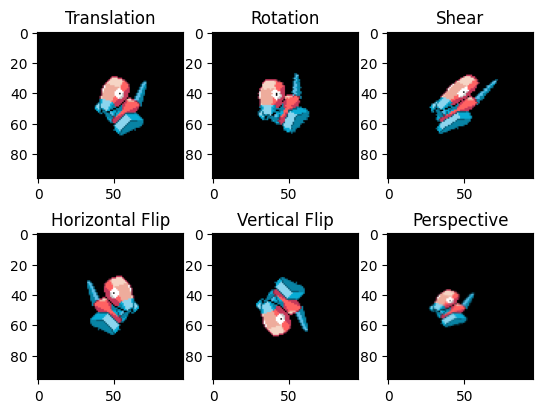

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784145E0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088F910>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7860E3B0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786E9E10>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781430D0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BFF40>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80923B80>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


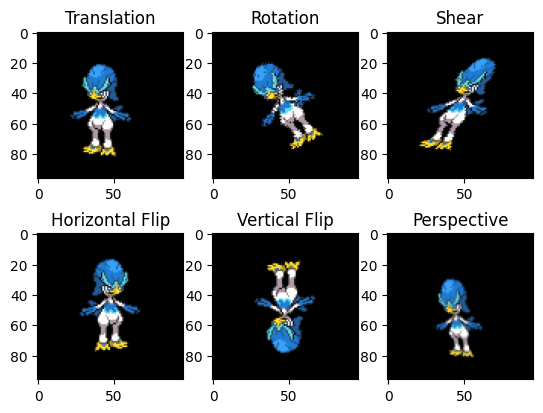

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78142AD0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785175E0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857E1D0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012C1C0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80113A60>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803ADF00>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80176E00>


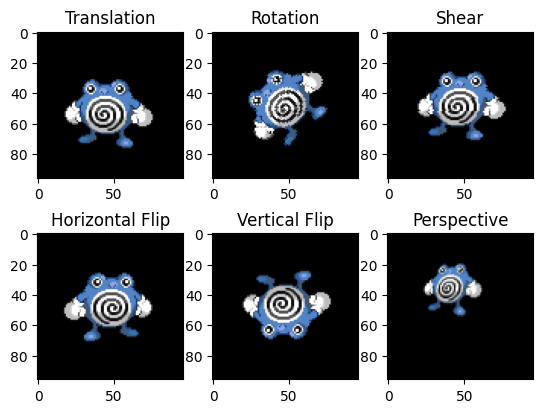

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801A58A0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E7BE0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F782BFEB0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78604610>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7869FE80>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8035C550>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80156A40>


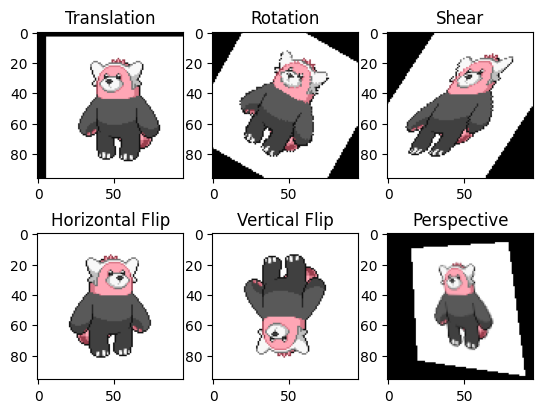

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E4970>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8035E2C0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F804C8730>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F804C89A0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80380580>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803817B0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78606FE0>


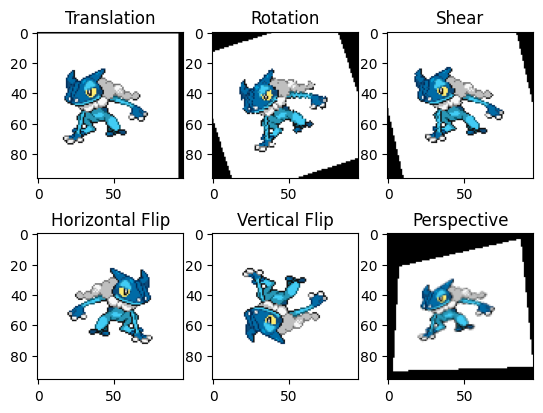

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78355870>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78230190>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803AF100>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7859B160>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784AA560>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7864F6A0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785E1390>


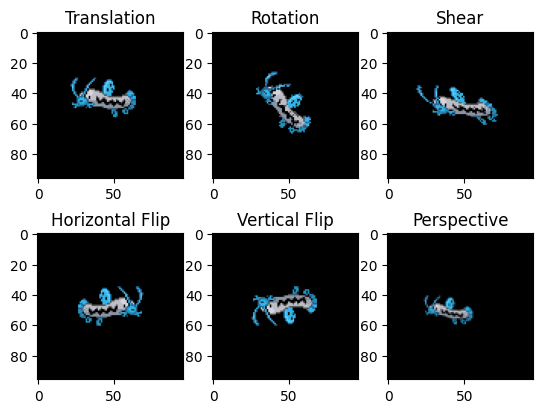

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78231F60>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7821E3B0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BCA90>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786EAA10>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786B9930>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786E8880>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801A7F40>


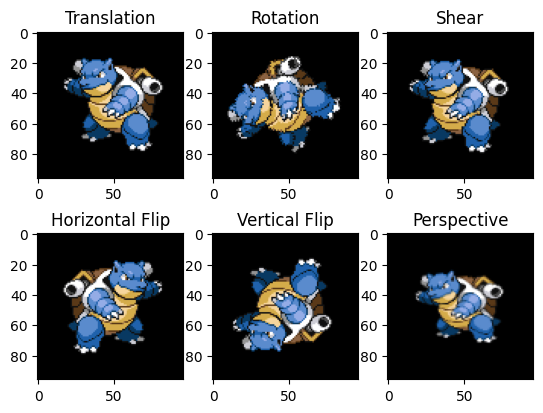

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787F8580>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78113730>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801C5D80>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783882B0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088F070>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787DF8E0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78141D50>


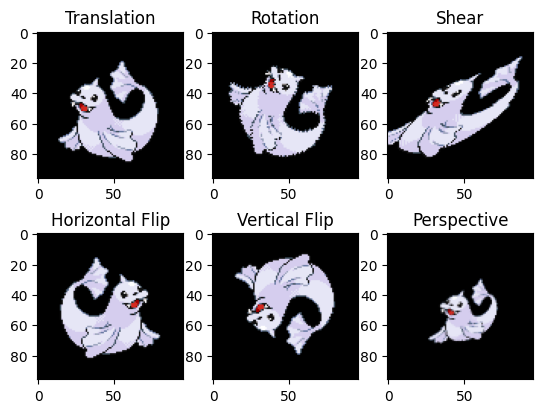

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  no

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


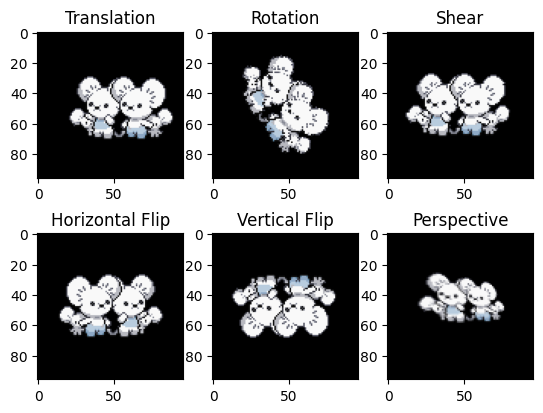

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  no

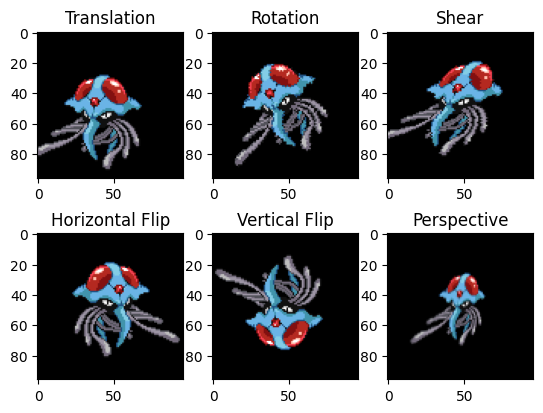

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  no

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7859C5E0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8250B9D0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784155A0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8049F100>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786F2F80>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78165B10>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82508F10>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


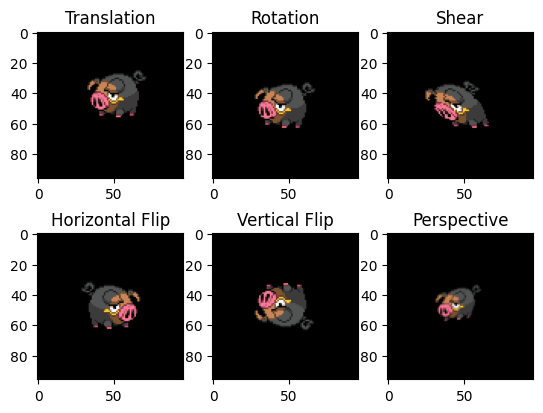

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083DC90>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F805AD360>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80985210>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80543040>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7852A740>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807A6170>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784EBAF0>


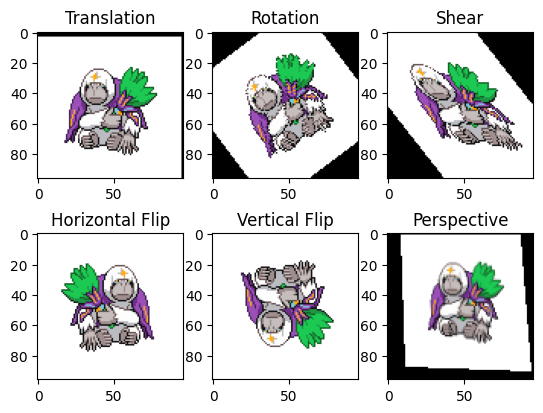

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783BA200>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857CDF0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088DF00>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786BB730>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7821FDC0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808EBDF0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857E140>


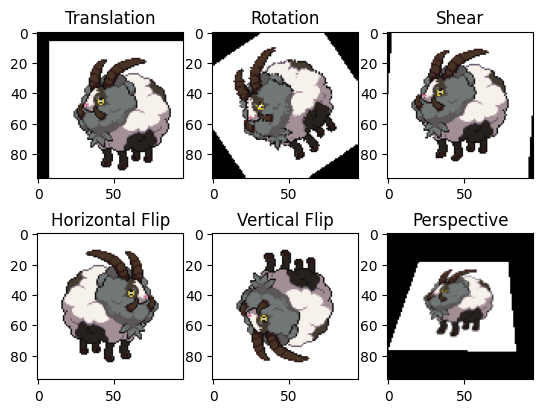

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F805AD1B0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78233580>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80971AB0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80157B80>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807FB010>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78606B90>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80175360>


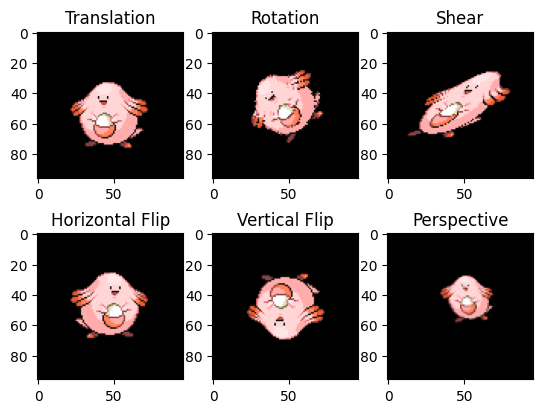

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F826DFE50>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80875B40>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801A5AB0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80525210>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7869E560>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78080160>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78142740>


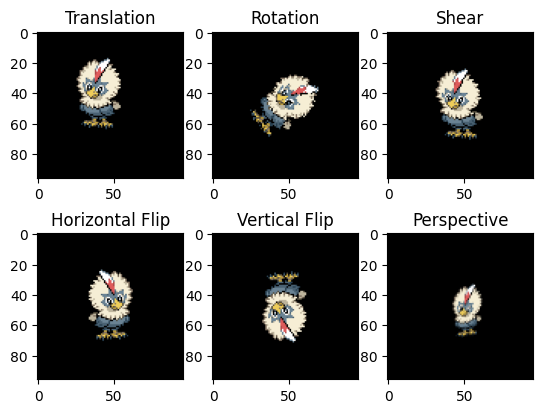

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786F1510>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F823D0940>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824C7AF0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78142500>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8233D0F0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8233CFA0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F823A6530>


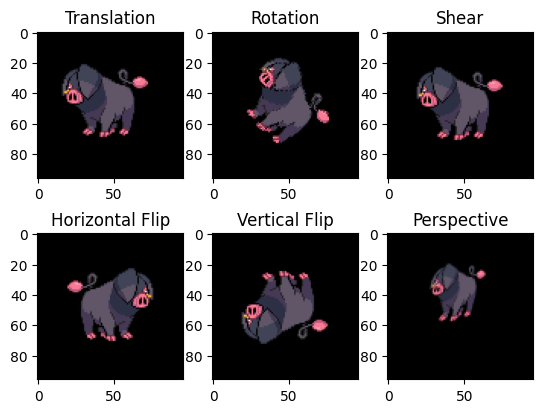

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78143D90>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78605990>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80876500>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780E6770>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80876500>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A82E0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F782BD990>


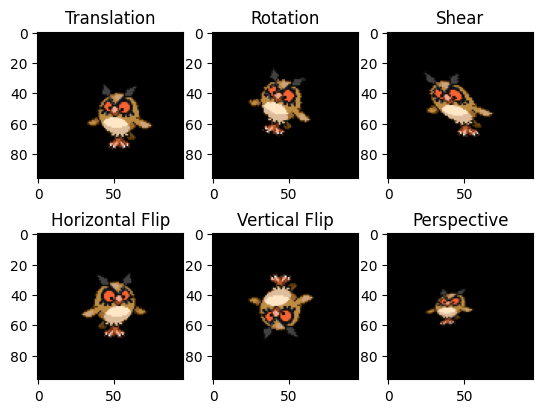

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  wa

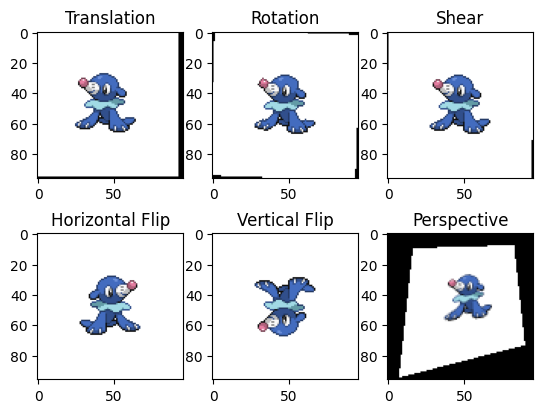

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  wa

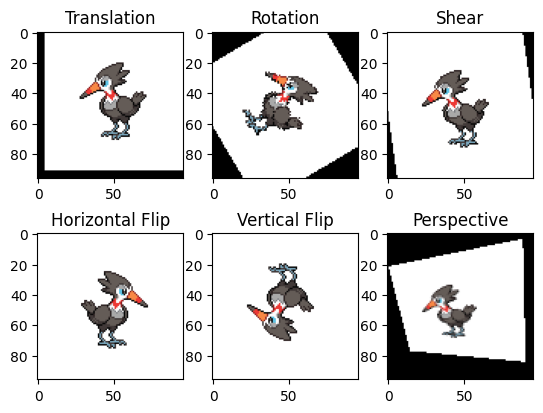

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  wa

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78388670>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7822E020>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8016DD20>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7872B760>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78167CA0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78675C90>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78317A30>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


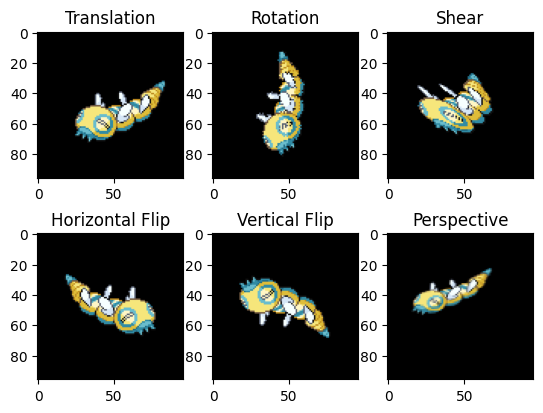

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80922EF0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783B8E80>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78106DA0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F73EDEA10>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785BBB20>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808C9B40>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80996380>


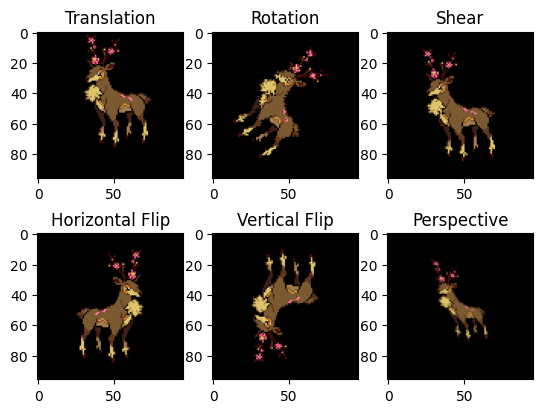

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BACB0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78415F00>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824563B0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82456B00>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808E9240>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808E9030>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8015F8E0>


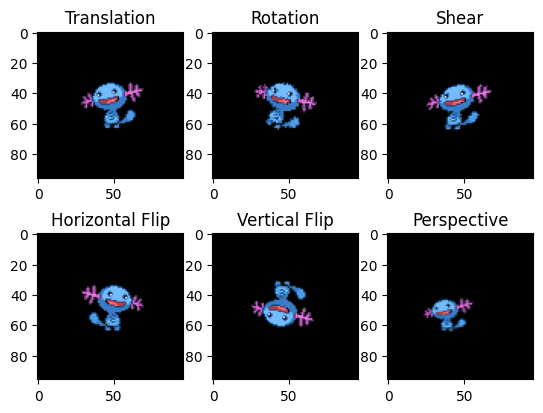

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809972E0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82430730>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786765F0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786DF400>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78476590>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78728400>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803E8C40>


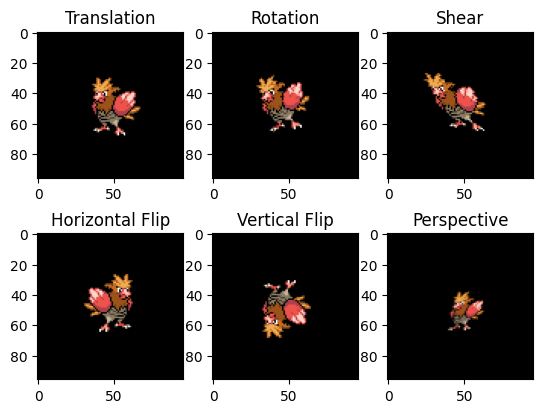

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78314460>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BF250>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781125C0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7860C760>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787DF9D0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80540A30>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781675B0>


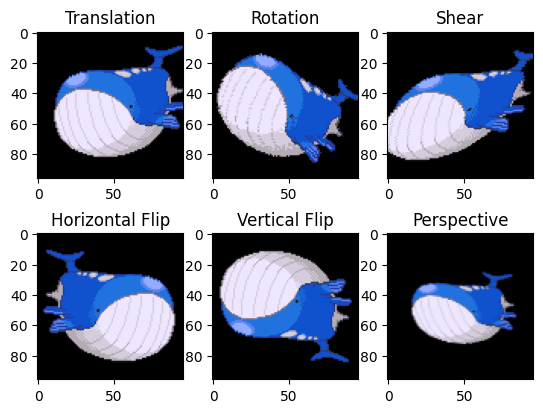

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80920970>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78642980>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785E24A0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803AEB90>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78642980>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786BAE00>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801C53C0>


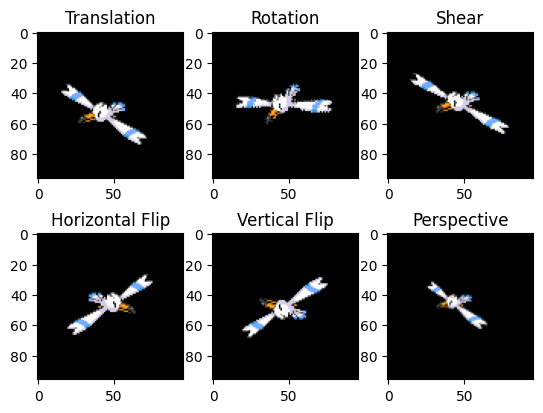

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012E4D0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780818A0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784CBC10>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801579D0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784CBC10>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801A6740>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808CA200>


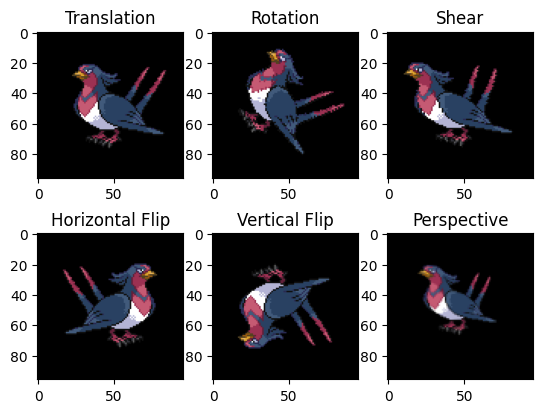

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  wate

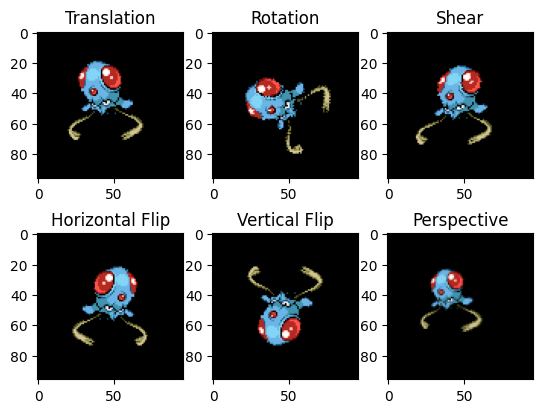

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  wate

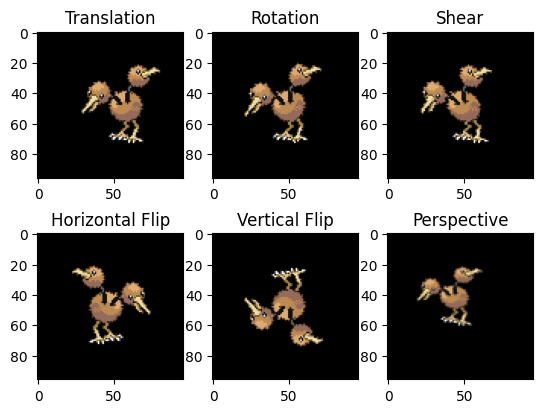

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  wate

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801A5180>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E7C10>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824C4E50>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809A42B0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E7C10>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80859690>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80524430>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


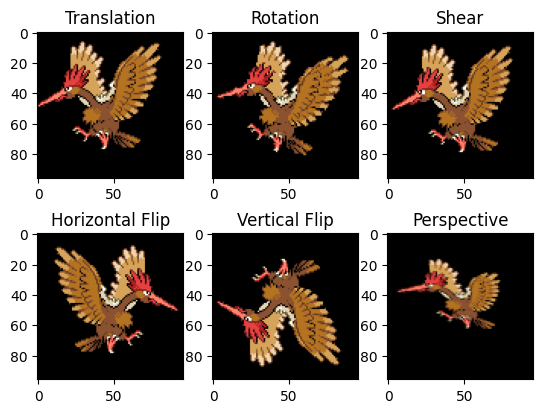

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E5120>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012FD00>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80970310>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78642440>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786B85B0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801C48E0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80176890>


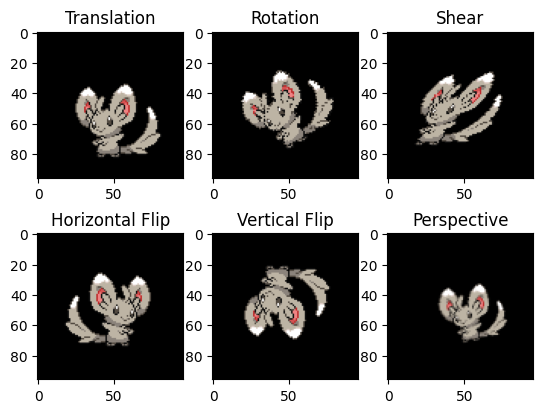

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F825B3010>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78529D80>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78529D80>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80135BA0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083CC40>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786E8850>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78316020>


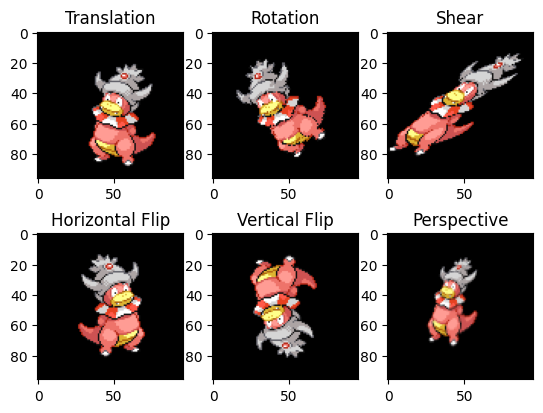

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857C8E0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78106E60>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783BB6D0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786DE500>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786DE500>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784EA710>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809878E0>


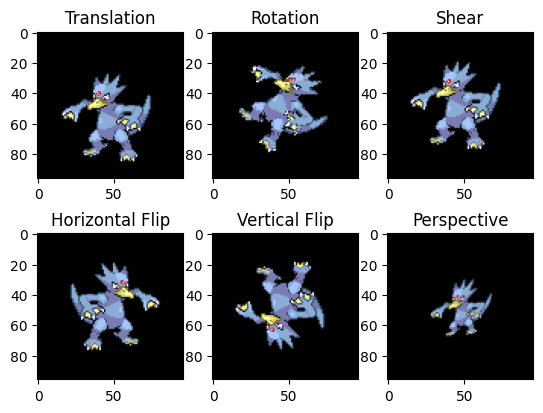

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82454730>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80920E50>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78476D10>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8015F160>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F782307F0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8049D150>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8095E110>


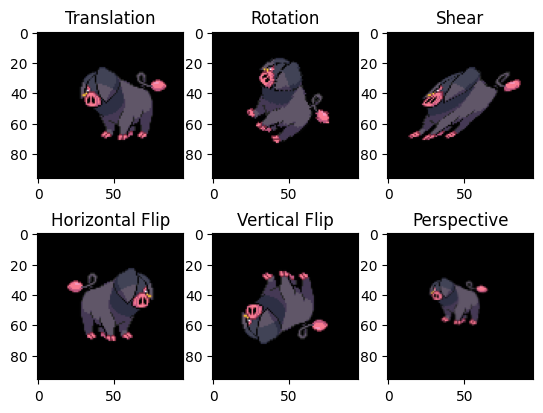

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785BB7F0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78107B20>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82509CC0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824551E0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784E9A80>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784172E0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787F9BD0>


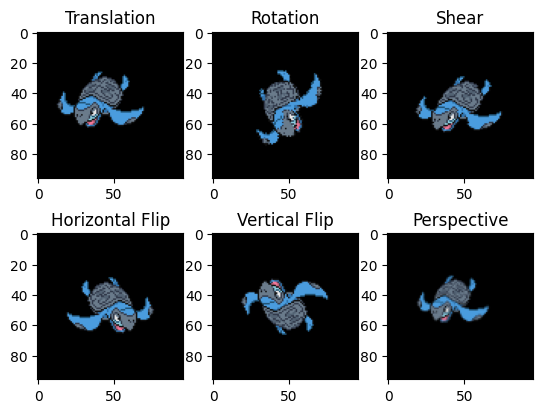

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80136DA0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083E050>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783148E0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78677A90>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80134B50>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BEC20>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7852BC10>


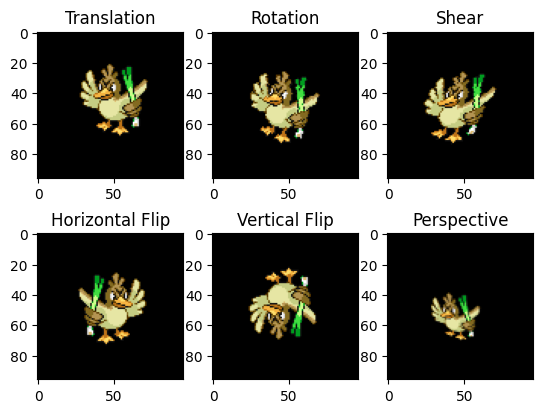

Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  |

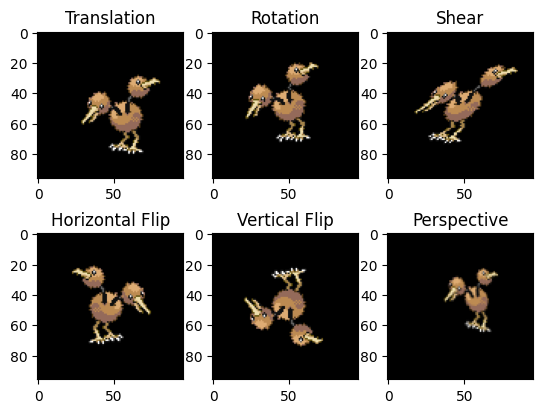

Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  |

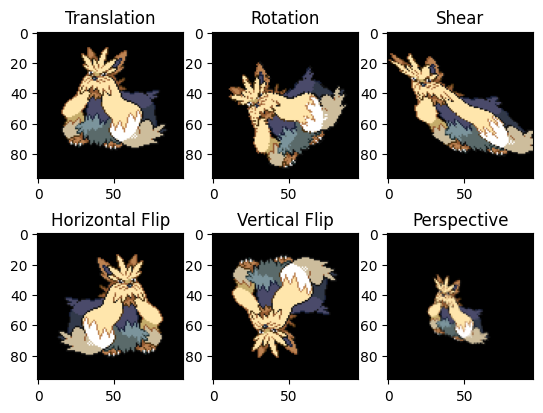

Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  |

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784E8B80>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088DAB0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80176890>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A2A70>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088DAB0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80525A80>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F782BC640>


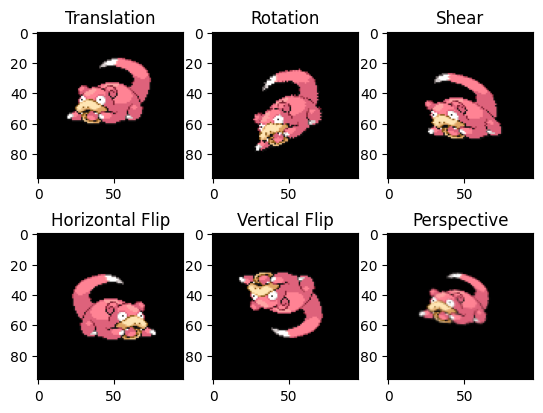

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7812E1D0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F823C3940>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82489C00>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012D030>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8240E6B0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8240ED40>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F823C03A0>


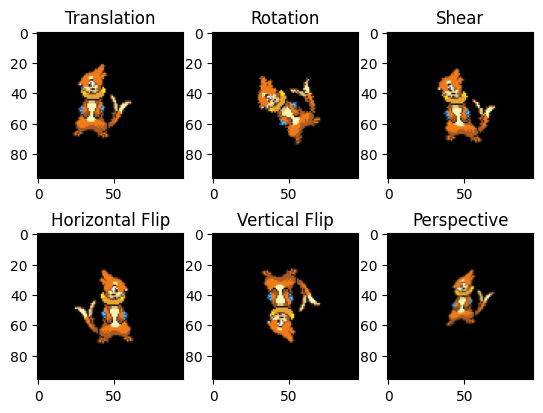

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012EEC0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A91E0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80526230>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80175900>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824C7700>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801A65C0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80155DB0>


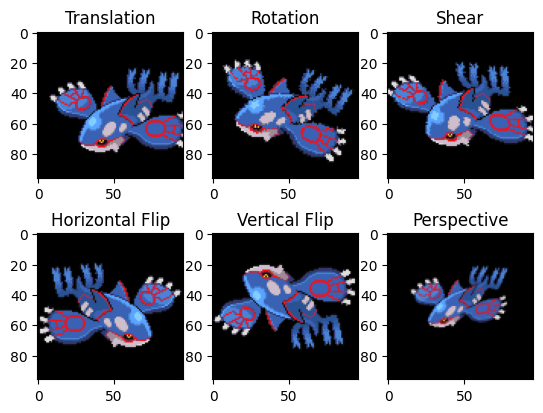

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809A54E0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784AA290>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786B99C0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80973B80>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8085AA10>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80876DD0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784A9D50>


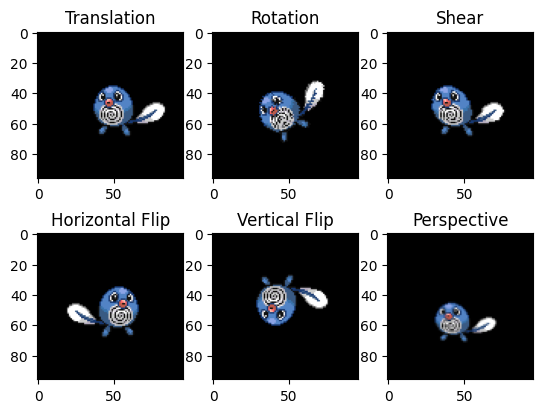

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8085BFD0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083E500>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801C5600>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BCE80>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BCE80>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787DD4B0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78388040>


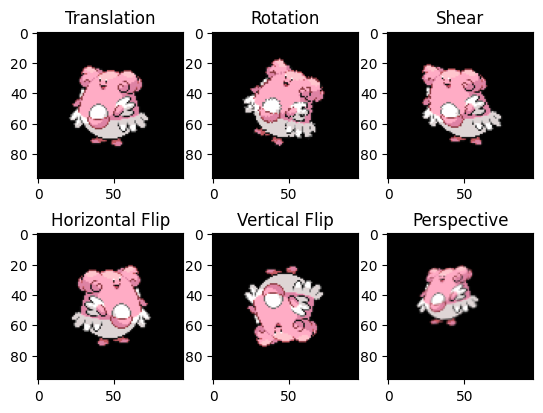

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8085BFD0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808B05E0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80137B20>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783BA650>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808B05E0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786BE860>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808B3820>


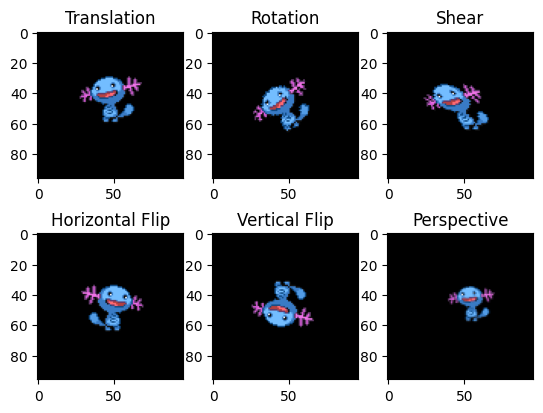

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808B0C10>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088EAD0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784748B0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807E12A0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809227A0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7859D0C0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F73EDC550>


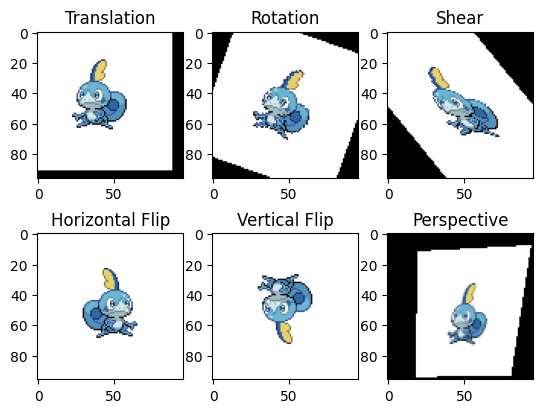

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  

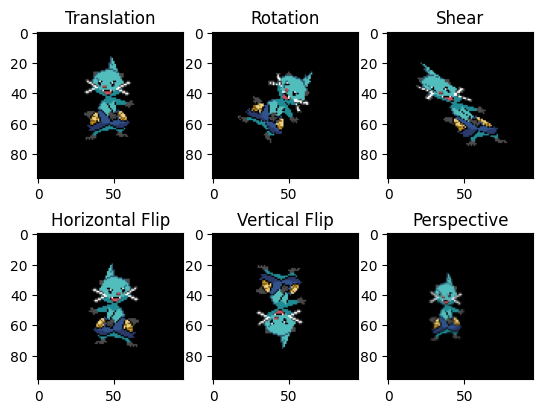

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  

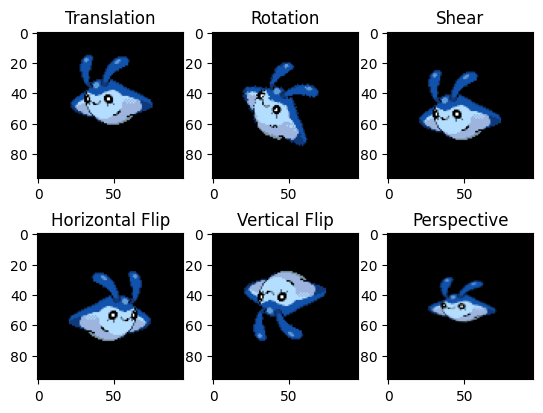

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80984970>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801C4700>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083E1A0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78389C60>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083E1A0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786BC880>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8035CCD0>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


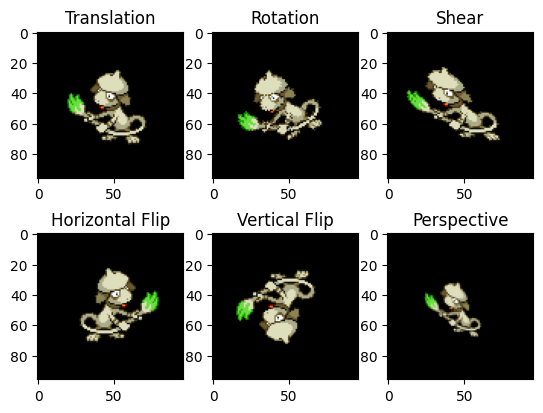

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801C60E0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801AC3A0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78516230>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7852A860>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801AC3A0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785E0D90>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784AB1F0>


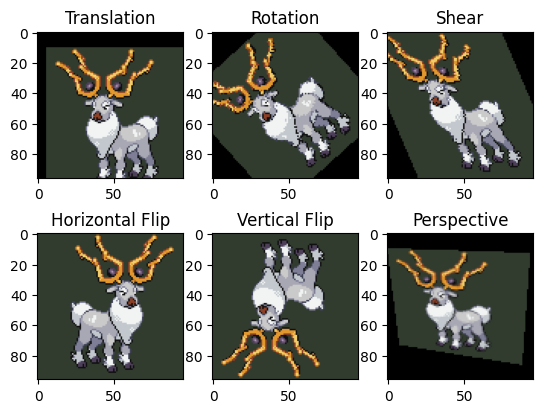

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783390C0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824C79D0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780AA140>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80525210>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80859300>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808C9090>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A3CD0>


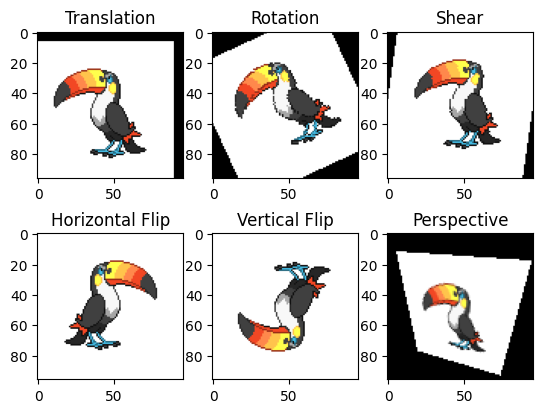

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012CA60>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78176DD0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78599840>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78640040>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78176DD0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8243EBC0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E45E0>


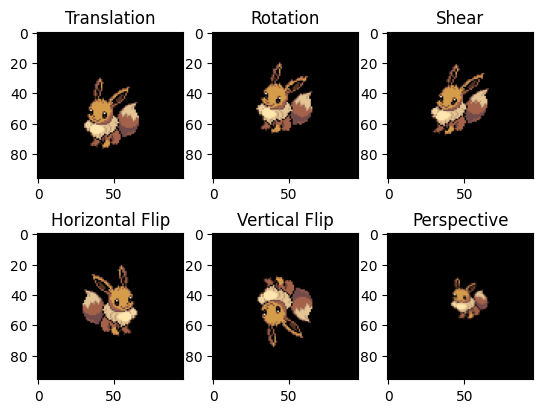

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088E260>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824ACF10>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82515660>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7860FDC0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786F0340>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E6B90>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786079D0>


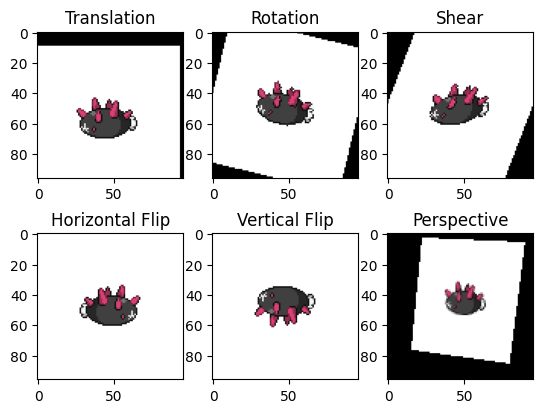

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824AD450>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012E560>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7821CC10>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8088C700>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786DE9E0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8243EF50>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A9A50>


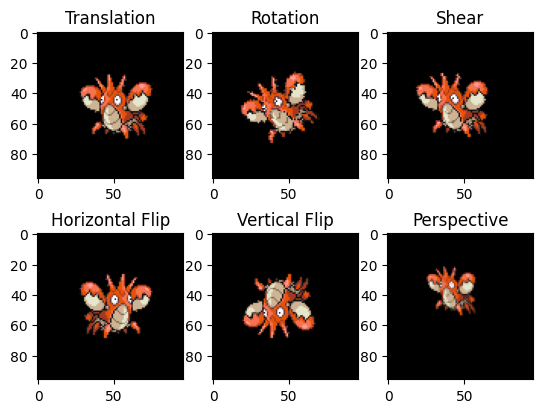

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8012FBB0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78143520>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7869EF20>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785E0CD0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785E0CD0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78514D90>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8035C1C0>


Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  nor

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  nor

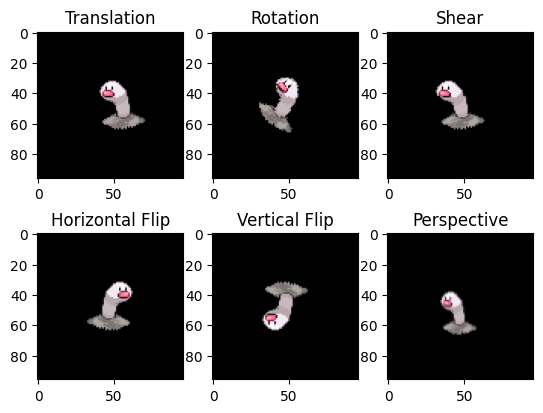

Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  nor

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78417A60>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8250A080>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78231090>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781663E0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8250A080>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80997850>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8250A0B0>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786E8130>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82455690>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780E6200>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786771C0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786771C0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781044F0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824333D0>


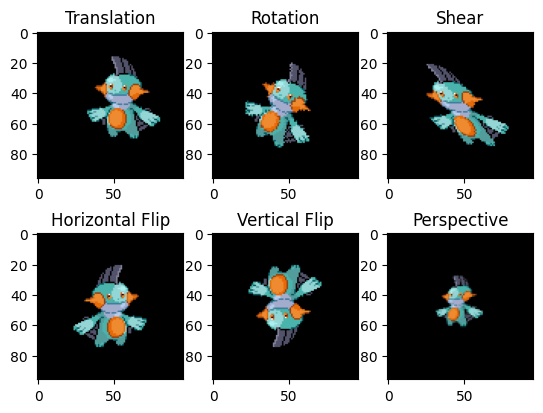

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824576A0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803AD780>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787DD9C0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78082350>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803AD780>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78338BB0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801551E0>


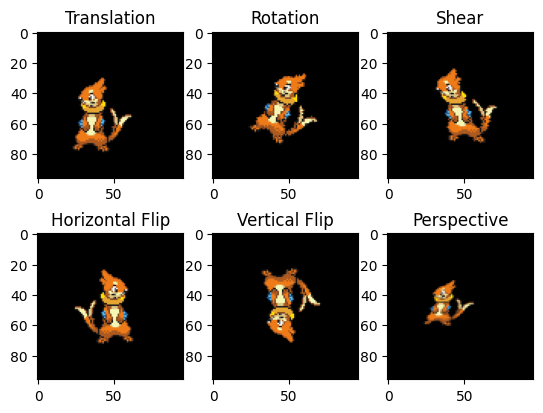

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8095E230>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784CB730>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BDF60>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80382BF0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784CB730>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780AAAD0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80177970>


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7852B8B0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809A57E0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80527DF0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7860C5B0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80527DF0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E73D0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A3CA0>


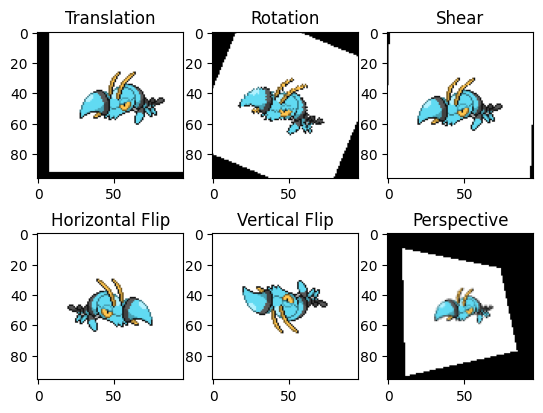

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F782312A0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78417880>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F73E135E0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857C400>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857C400>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781755A0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7822E2F0>


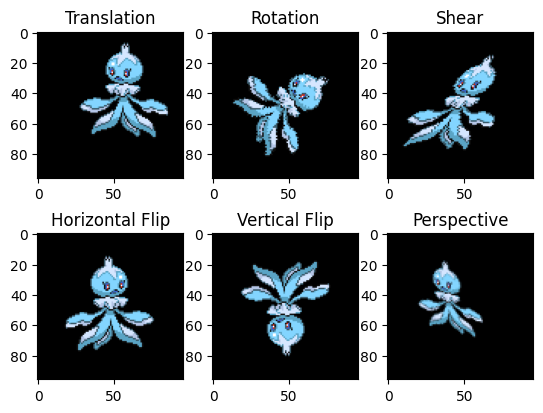

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083D840>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82232F80>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824F2620>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82497190>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F823B5DB0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F823B5E70>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F822308B0>


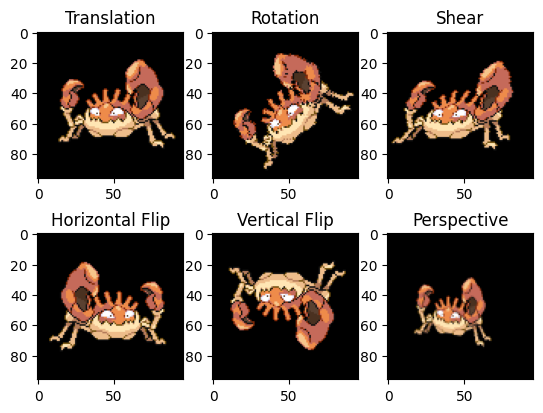

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


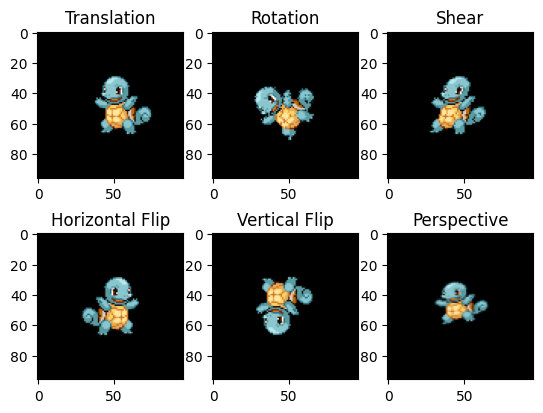

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred

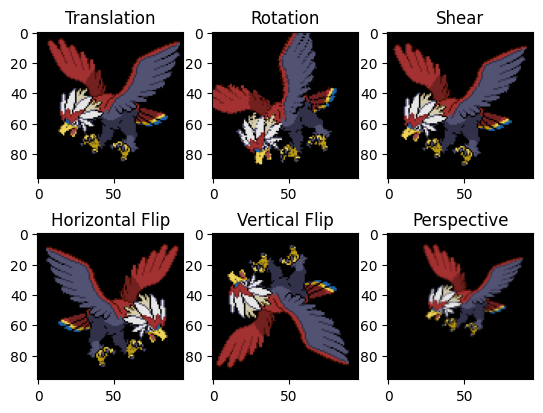

Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786BD4E0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82723370>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78141120>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780834F0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82723370>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78514760>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785E2110>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


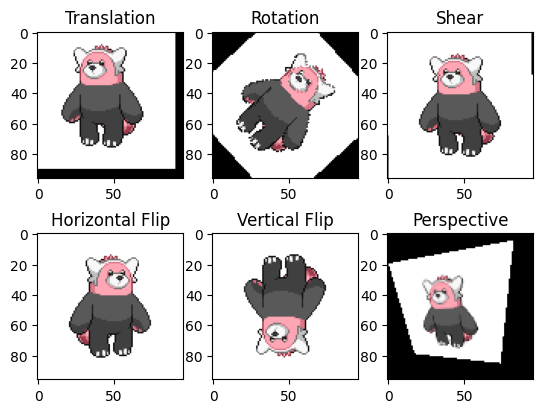

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808EB700>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781656C0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80136590>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785BA380>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787F9150>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8016D930>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F781673D0>


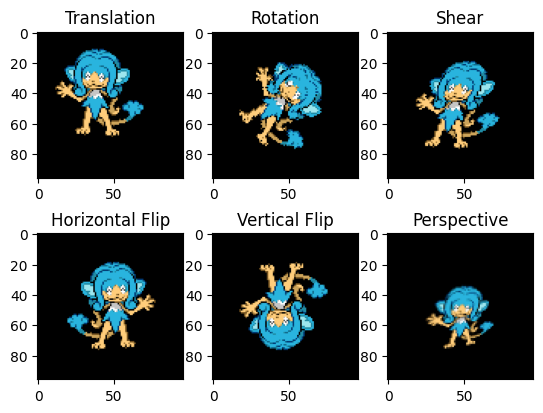

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780A00A0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807A4E50>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784C8CA0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807A4E50>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857EB00>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786763B0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F805AD7B0>


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78106080>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786BA650>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80995150>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78676320>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F73EDF0A0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784EAE90>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78107220>


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F73EDC880>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786DF430>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784CB760>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8049DDE0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803E9660>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78314F10>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F785BA140>


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78677670>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82454A00>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780B84F0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F783BB160>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787DCC10>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78080DC0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807E2350>


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803AF580>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7864D5A0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7838B160>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824C4BE0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807FAAA0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80381D80>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7869C1C0>


Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Exp

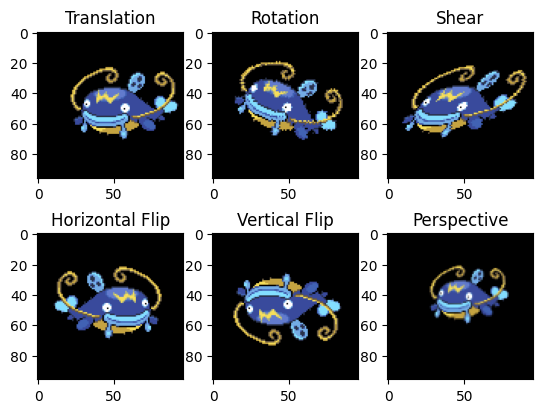

Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Exp

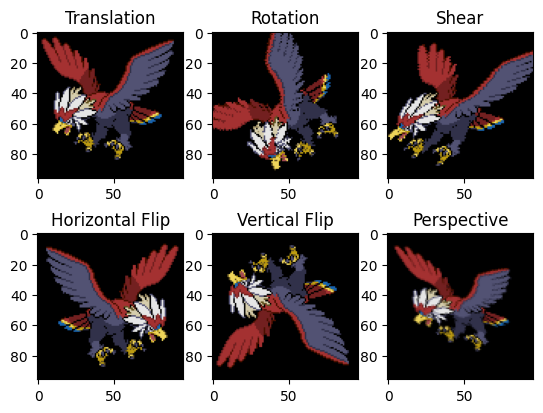

Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  normal
Expected:  normal  | Pred:  normal
Exp

Training:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80526EF0>


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8018B070>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80525420>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80525D50>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8015C5B0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8015EF50>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8083DED0>


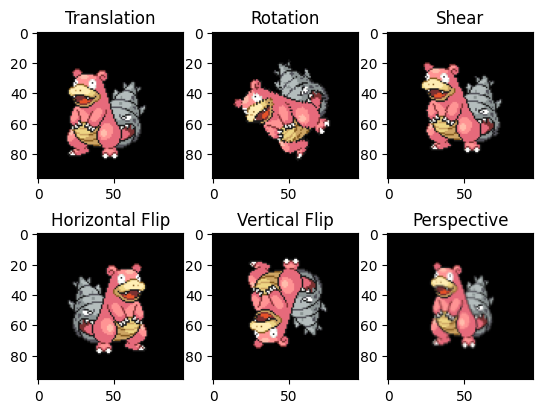

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80525090>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F801C59C0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F782BE920>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F803C1360>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784154B0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7812C040>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8243E8C0>


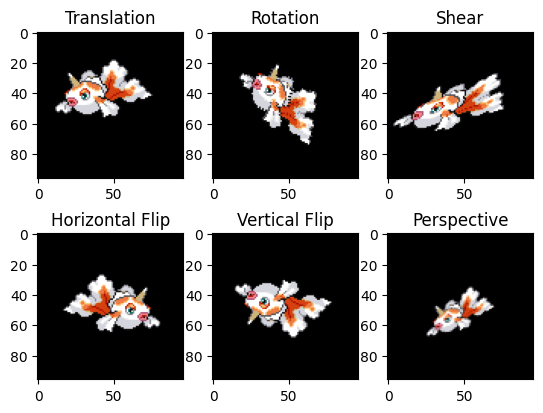

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80858AF0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808CB580>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78138730>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809A4460>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824C7340>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80971000>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780BD120>


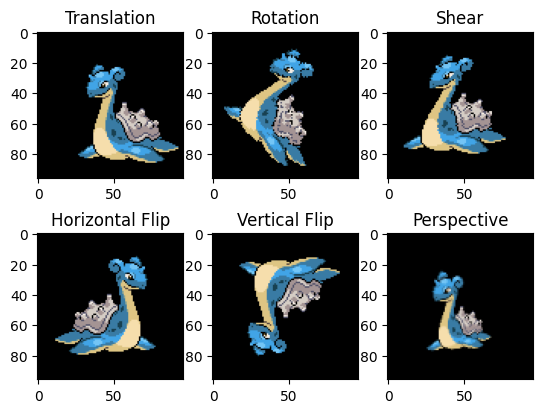

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807E2FB0>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78164F40>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F787F8430>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F807F8D60>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78164F40>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78529000>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F82722E30>


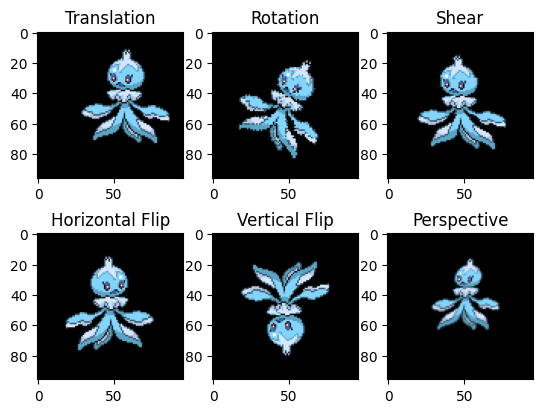

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F8016DB70>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784EBAC0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786E98A0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7857CAF0>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786DD3C0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F80176680>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784EB940>


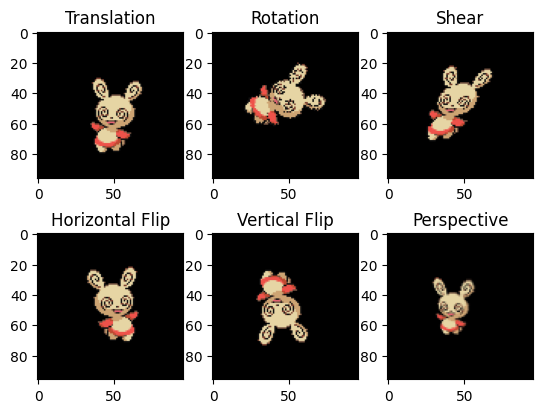

<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78316B60>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809E6C80>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809239A0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F780E6860>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F809239A0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786B8C70>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F7859DC30>


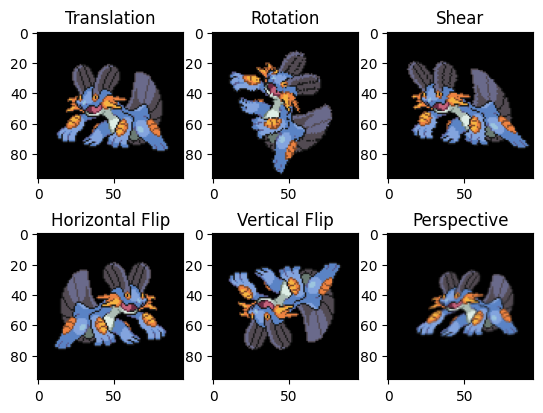

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F78475390>
Translation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F824311B0>
Rotation <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784C97B0>
Shear <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F808B0E20>
Horizontal Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F784C97B0>
Vertical Flip <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F786F06A0>
Perspective <PIL.Image.Image image mode=RGB size=96x96 at 0x7F7F804C8430>


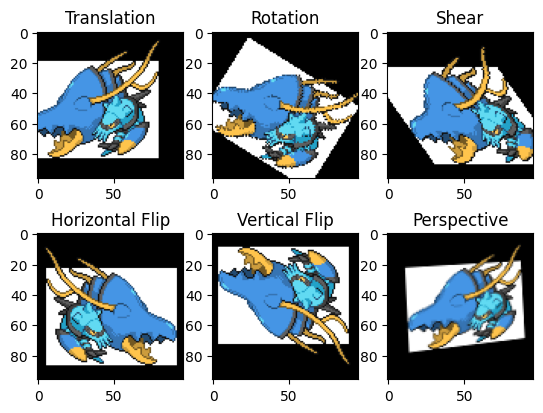

Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | 

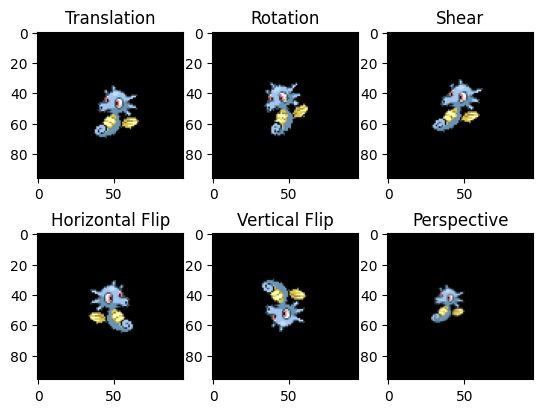

Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | 

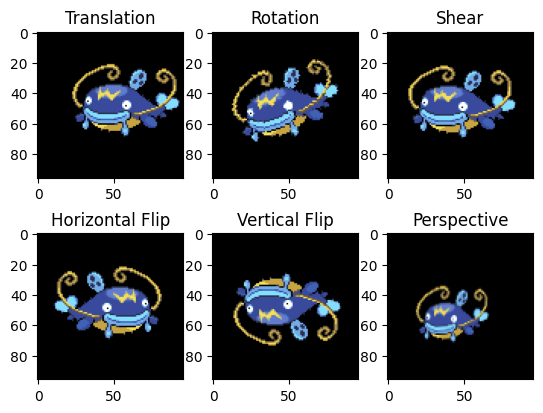

Expected:  water  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  water  | Pred:  water
Expected:  normal  | Pred:  normal
Expected:  normal  | 

In [20]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func,
    train_loader, test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)
# cnn_pool_results = train_simple_network(model_cnn_pool, loss_func,
#     train_loader, test_loader=test_loader,
#     score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)
# fc_results = train_simple_network(model_linear, loss_func,
#     train_loader, test_loader=test_loader,
#     score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

   epoch  total time  train loss  test loss  train Accuracy  test Accuracy
0      0    5.391985    1.602034   0.924682        0.392045       0.506667
1      1   10.475067    0.919233   0.935232        0.500000       0.506667
2      2   15.972468    0.919770   1.351588        0.511364       0.506667
3      3   20.891125    1.050725   0.652570        0.482955       0.666667
4      4   26.560065    0.605978   1.547186        0.664773       0.506667
5      5   31.777582    0.771061   0.648680        0.625000       0.546667
6      6   37.254196    0.589714   0.818812        0.693182       0.586667
7      7   42.617999    0.541120   0.716822        0.755682       0.560000
8      8   47.744541    0.697081   0.656134        0.573864       0.680000
9      9   52.925066    0.603054   1.001605        0.693182       0.560000


<Axes: xlabel='epoch', ylabel='test Accuracy'>

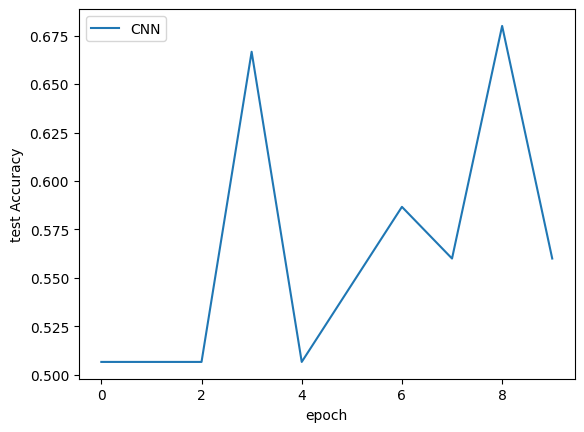

In [12]:
print(cnn_results)
# print(cnn_pool_results)
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
# sns.lineplot(x='epoch', y='test Accuracy', data=cnn_pool_results, label='CNN with Max Pooling')